In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import os
import imageio
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import rescale
import time

In [2]:
device = torch.device('cuda:0')
dtype = torch.float32
torch.backends.cudnn.benchmark = True

In [3]:
def read_all_image_folders(directories, y_scale):
    x_images, y_images = [], []
    for ix in directories:
        directory = f"../data/CAT_0{ix}/x1"
        for filename in os.listdir(directory):
            if filename.endswith(".jpg"):
                image = imageio.imread(f'{directory}/{filename}')
                y_images.append(scale_image(image, y_scale))        
                x_images.append(scale_image(image, y_scale / 2))
    return x_images, y_images

In [4]:
def scale_image(image, scale):
    image = rescale(image=image, scale=scale, multichannel=True, anti_aliasing=True) 
    return image

In [5]:
learning_rate = 0.001
batch_size = 16
epochs = 21

In [6]:
class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        
        self.generator = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 9, stride = 1, padding = 4),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 256, kernel_size = 3, stride = 1, padding = 1)
        )
        
        self.generator_2 = nn.Sequential(
            nn.Conv2d(256, 3, kernel_size = 9, stride = 1, padding = 4),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.generator(x)
        x = F.interpolate(x, scale_factor = 2)
        x = F.relu(x)
        x = self.generator_2(x)
        return x

In [7]:
model = generator().cuda()

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

In [9]:
def train(directories, epochs, batch_size, y_scale):
    
    l_start = time.time()
    
    x_images, y_images = read_all_image_folders(directories, y_scale)
    x = torch.tensor(x_images, device = device, dtype = dtype)
    y = torch.tensor(y_images, device = device, dtype = dtype)
    del x_images, y_images
    
    print(f'Data loaded (m): {round((time.time() - l_start) / 60, 2)} @ {directories} in {y_scale}')
    print('----------')
    
    loss_hist = []
    psnr_hist = []
    
    start = time.time()

    for t in range(epochs):
        for batch in range(0, int(x.shape[0]/batch_size)):
            
            batch_x = x[batch * batch_size : (batch + 1) * batch_size, :].transpose(1, 3)
            batch_y = y[batch * batch_size : (batch + 1) * batch_size, :].transpose(1, 3)
        
            outputs = model.forward(batch_x)

            loss = criterion(outputs, batch_y)
            psnr = 10 * math.log10(1 / F.mse_loss(outputs, batch_y))
            
            del batch_x, batch_y
            torch.cuda.empty_cache()
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if t % 5 == 0:
            loss_hist.append(loss.item())
            psnr_hist.append(psnr)
            print(t, f"PSNR: {psnr}, BCE: {loss.item()}, Time (m): {round((time.time() - start) / 60, 2)}")
            
    print('----------')
    print(f'Train Time (m): {round((time.time() - start) / 60, 2)}')
    
    plt.figure(1, figsize=(14,5))
    plt.subplot(1,2,1) 
    plt.title('PSNR')
    plt.plot(psnr_hist)
    plt.subplot(1,2,2)
    plt.title('BCE')
    plt.plot(loss_hist)
    plt.show()
    
    print(f'Memory allocated before clear: {torch.cuda.memory_cached()/1000**2} MB')
    del x, y
    torch.cuda.empty_cache()
    print(f'Memory allocated after clear: {torch.cuda.memory_cached()/1000**2} MB')
    print('----------')
    
    return psnr

/home/alex/.conda/envs/super-scaler/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Data loaded (m): 2.46 @ [0] in 1
----------
0 PSNR: 21.339872532879443, BCE: 0.5236281752586365, Time (m): 1.13
5 PSNR: 24.30282544210781, BCE: 0.5128571391105652, Time (m): 6.33
10 PSNR: 25.915142494764204, BCE: 0.5093461275100708, Time (m): 11.53
15 PSNR: 27.086718422860297, BCE: 0.5075145959854126, Time (m): 16.73
20 PSNR: 28.673381694251535, BCE: 0.5057111978530884, Time (m): 21.93
----------
Train Time (m): 21.93


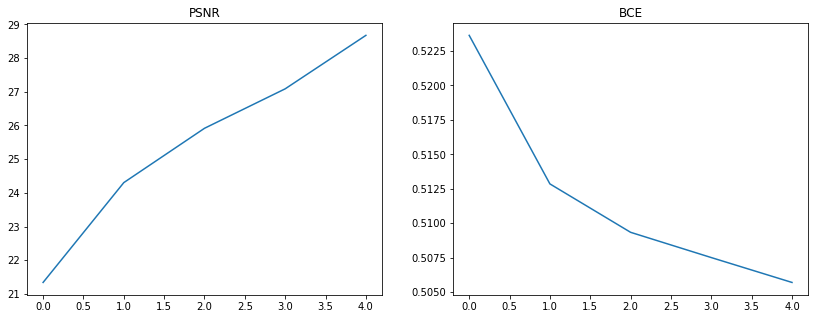

Memory allocated before clear: 7525.761024 MB
Memory allocated after clear: 373.948416 MB
----------
Data loaded (m): 2.36 @ [1] in 1
----------
0 PSNR: 26.621363112031254, BCE: 0.5384354591369629, Time (m): 1.0
5 PSNR: 26.924436124582645, BCE: 0.5381063222885132, Time (m): 6.0
10 PSNR: 26.98860224016238, BCE: 0.5379840731620789, Time (m): 11.0
15 PSNR: 27.32781328729041, BCE: 0.5375931859016418, Time (m): 16.0
20 PSNR: 27.5290226679618, BCE: 0.5373265147209167, Time (m): 21.0
----------
Train Time (m): 21.0


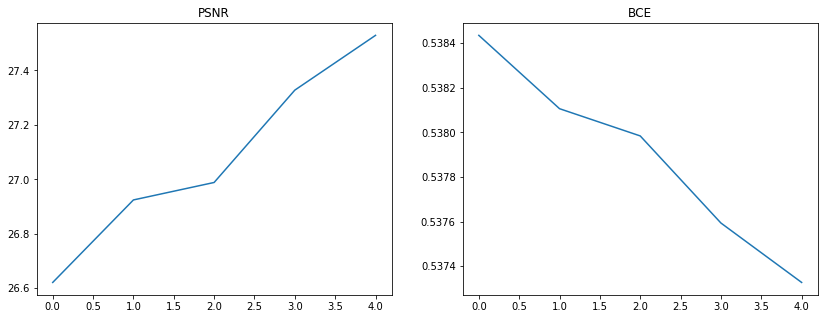

Memory allocated before clear: 7420.116992 MB
Memory allocated after clear: 373.948416 MB
----------
Data loaded (m): 1.59 @ [0, 1] in 0.5
----------
0 PSNR: 29.744228014921624, BCE: 0.5281972289085388, Time (m): 0.41
5 PSNR: 30.072571432177174, BCE: 0.5279765129089355, Time (m): 2.33
10 PSNR: 30.063307167671077, BCE: 0.5279730558395386, Time (m): 4.25
15 PSNR: 30.46309740847969, BCE: 0.5276724100112915, Time (m): 6.16
20 PSNR: 30.378057504888766, BCE: 0.5276944637298584, Time (m): 8.08
----------
Train Time (m): 8.08


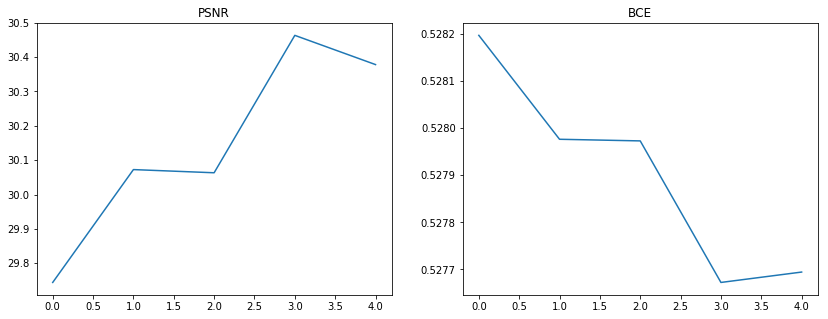

Memory allocated before clear: 4645.19168 MB
Memory allocated after clear: 44.826624 MB
----------
Data loaded (m): 2.55 @ [2] in 1
----------
0 PSNR: 29.501427252235707, BCE: 0.5260208249092102, Time (m): 1.06
5 PSNR: 29.92357945893135, BCE: 0.5255116820335388, Time (m): 6.41
10 PSNR: 29.799556559457898, BCE: 0.5255830883979797, Time (m): 11.76
15 PSNR: 30.041032248502553, BCE: 0.5253855586051941, Time (m): 17.11
20 PSNR: 30.157904122573047, BCE: 0.5252766609191895, Time (m): 22.46
----------
Train Time (m): 22.46


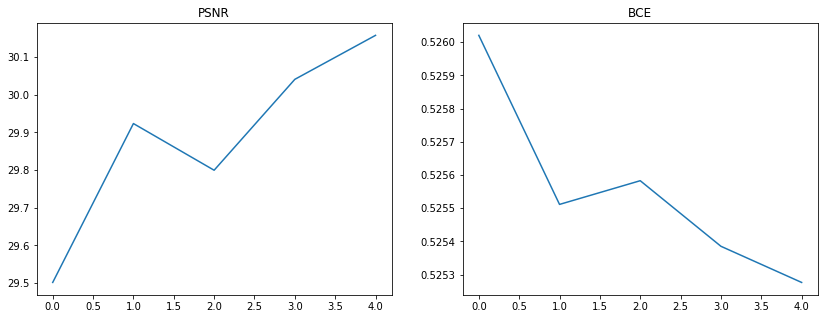

Memory allocated before clear: 8974.368768 MB
Memory allocated after clear: 1479.80288 MB
----------
Data loaded (m): 2.07 @ [2, 3, 4] in 0.5
----------
0 PSNR: 29.61524358597902, BCE: 0.4897233247756958, Time (m): 0.45
5 PSNR: 30.353609849550054, BCE: 0.4891672432422638, Time (m): 2.74
10 PSNR: 30.65984678526752, BCE: 0.48900023102760315, Time (m): 5.02
15 PSNR: 30.76371288552515, BCE: 0.48887985944747925, Time (m): 7.3
20 PSNR: 30.729813835965526, BCE: 0.4889051020145416, Time (m): 9.58
----------
Train Time (m): 9.58


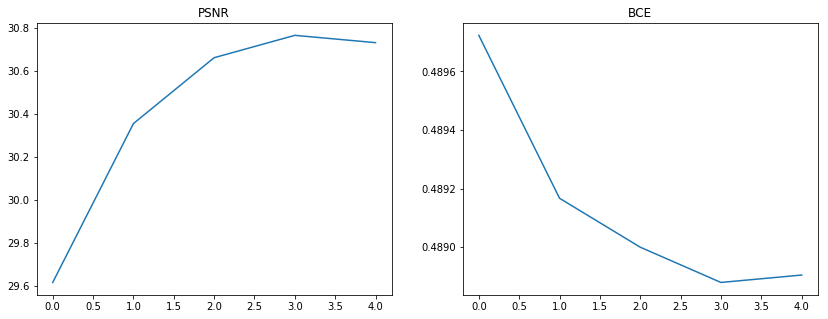

Memory allocated before clear: 4827.119616 MB
Memory allocated after clear: 1479.80288 MB
----------
Data loaded (m): 1.19 @ [3] in 1
----------
0 PSNR: 28.443368050459533, BCE: 0.5331073999404907, Time (m): 0.49
5 PSNR: 28.02352452620426, BCE: 0.5337168574333191, Time (m): 2.93
10 PSNR: 28.47818496835245, BCE: 0.5329668521881104, Time (m): 5.37
15 PSNR: 28.443484505990448, BCE: 0.532966673374176, Time (m): 7.81
20 PSNR: 28.63122666232584, BCE: 0.5327588319778442, Time (m): 10.24
----------
Train Time (m): 10.24


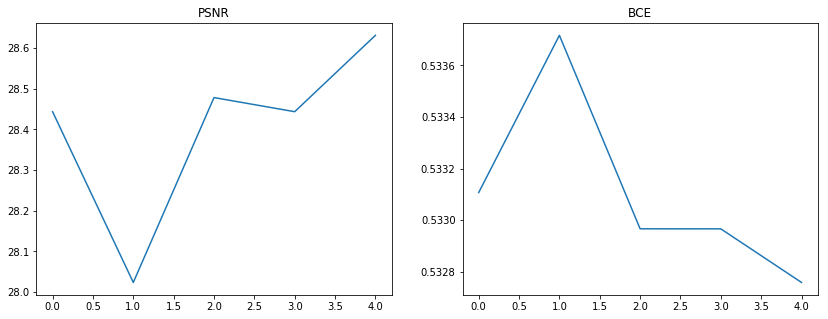

Memory allocated before clear: 6642.335744 MB
Memory allocated after clear: 373.948416 MB
----------
Data loaded (m): 3.15 @ [0, 1, 2, 3, 4, 5, 6] in 0.2
----------
0 PSNR: 28.133097646390112, BCE: 0.5417382121086121, Time (m): 0.34
5 PSNR: 28.395811870010924, BCE: 0.5414499044418335, Time (m): 2.01
10 PSNR: 28.705903089918205, BCE: 0.5411903262138367, Time (m): 3.68
15 PSNR: 28.92097151455267, BCE: 0.5410061478614807, Time (m): 5.35
20 PSNR: 29.109498919898673, BCE: 0.5408517122268677, Time (m): 7.02
----------
Train Time (m): 7.02


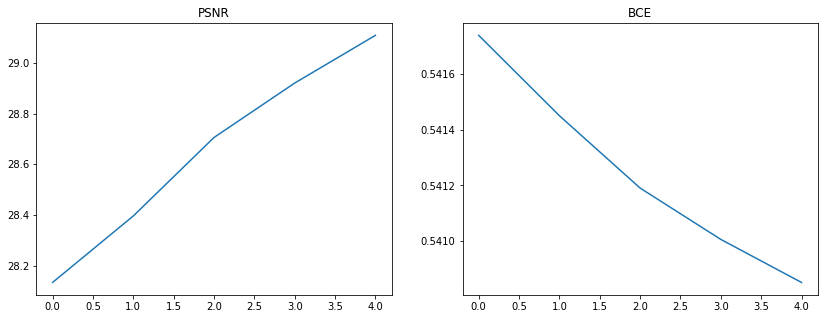

Memory allocated before clear: 1354.366976 MB
Memory allocated after clear: 6.291456 MB
----------
Data loaded (m): 2.03 @ [4] in 1
----------
0 PSNR: 30.68146892101852, BCE: 0.49727362394332886, Time (m): 0.85
5 PSNR: 31.367631701206683, BCE: 0.4968699514865875, Time (m): 5.09
10 PSNR: 31.53311437517917, BCE: 0.49667054414749146, Time (m): 9.34
15 PSNR: 31.534997883643957, BCE: 0.4966435134410858, Time (m): 13.59
20 PSNR: 31.492783269016638, BCE: 0.4966750144958496, Time (m): 17.84
----------
Train Time (m): 17.84


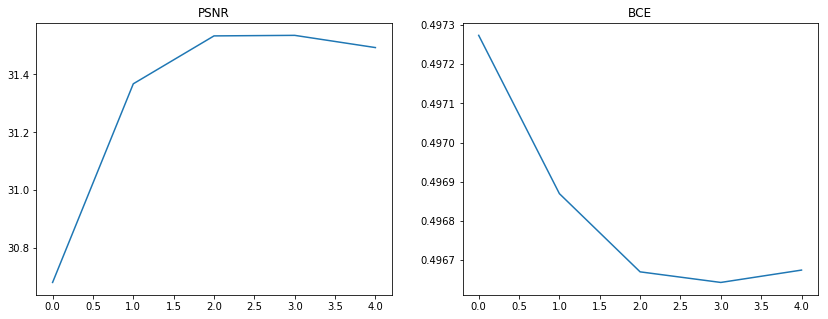

Memory allocated before clear: 7393.509376 MB
Memory allocated after clear: 373.948416 MB
----------
Data loaded (m): 1.3 @ [5, 6] in 0.5
----------
0 PSNR: 29.14053708907858, BCE: 0.5322432518005371, Time (m): 0.31
5 PSNR: 31.693191492614567, BCE: 0.5307500958442688, Time (m): 1.84
10 PSNR: 31.659433512472862, BCE: 0.5307498574256897, Time (m): 3.38
15 PSNR: 31.911490955435813, BCE: 0.5306419134140015, Time (m): 4.91
20 PSNR: 31.72365476946531, BCE: 0.5307106971740723, Time (m): 6.45
----------
Train Time (m): 6.45


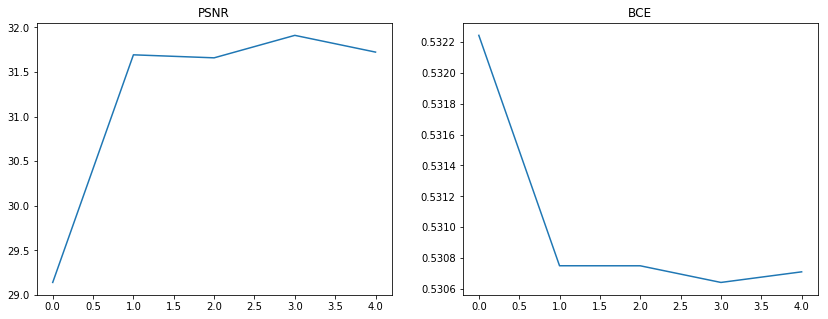

Memory allocated before clear: 4486.987776 MB
Memory allocated after clear: 97.517568 MB
----------
Data loaded (m): 1.92 @ [5] in 1
----------
0 PSNR: 29.65102869213753, BCE: 0.4951063096523285, Time (m): 0.81
5 PSNR: 29.812495036966045, BCE: 0.4949791133403778, Time (m): 4.85
10 PSNR: 29.86201837610452, BCE: 0.49495288729667664, Time (m): 8.9
15 PSNR: 29.900679249338822, BCE: 0.4949008822441101, Time (m): 12.95
20 PSNR: 29.798390789450035, BCE: 0.49499455094337463, Time (m): 17.0
----------
Train Time (m): 17.0


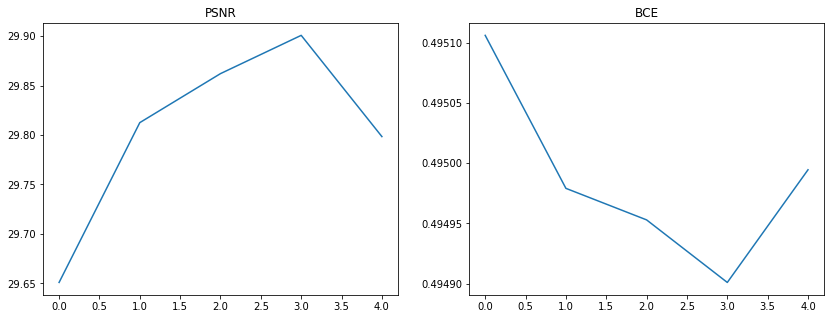

Memory allocated before clear: 7019.692032 MB
Memory allocated after clear: 97.517568 MB
----------
Data loaded (m): 2.02 @ [6] in 1
----------
0 PSNR: 30.126553418686115, BCE: 0.5421736240386963, Time (m): 0.84
5 PSNR: 30.625750991783768, BCE: 0.5419715046882629, Time (m): 5.09
10 PSNR: 30.975267480664982, BCE: 0.5416816473007202, Time (m): 9.34
15 PSNR: 31.0729735188546, BCE: 0.5416146516799927, Time (m): 13.59
20 PSNR: 31.08519149761416, BCE: 0.5415881276130676, Time (m): 17.84
----------
Train Time (m): 17.84


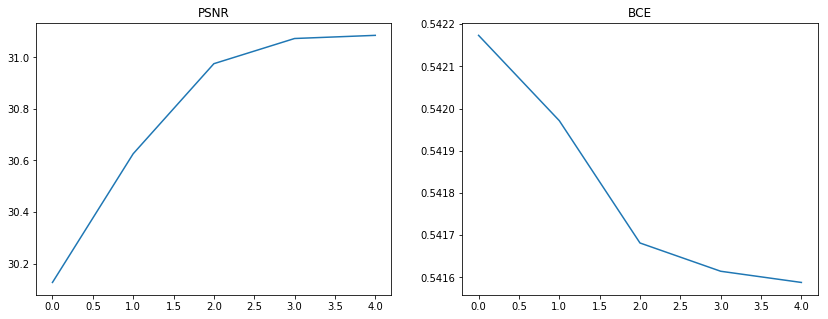

Memory allocated before clear: 7099.252736 MB
Memory allocated after clear: 97.517568 MB
----------
Data loaded (m): 2.48 @ [0] in 1
----------
0 PSNR: 31.221017521476266, BCE: 0.5032831430435181, Time (m): 1.03
5 PSNR: 31.697146772737952, BCE: 0.5029464364051819, Time (m): 6.22
10 PSNR: 31.721831017750866, BCE: 0.5029246807098389, Time (m): 11.4
15 PSNR: 31.921856358541323, BCE: 0.5028334259986877, Time (m): 16.58
20 PSNR: 31.878473598434628, BCE: 0.5028428435325623, Time (m): 21.76
----------
Train Time (m): 21.76


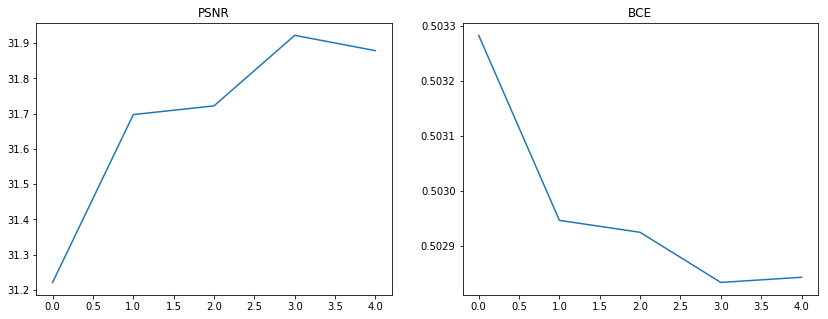

Memory allocated before clear: 7521.828864 MB
Memory allocated after clear: 97.517568 MB
----------
Data loaded (m): 2.38 @ [1] in 1
----------
0 PSNR: 27.42420071191836, BCE: 0.5374025106430054, Time (m): 1.0
5 PSNR: 28.197956812633915, BCE: 0.5364680290222168, Time (m): 5.99
10 PSNR: 28.263029423378324, BCE: 0.5364506840705872, Time (m): 10.99
15 PSNR: 28.304044885578147, BCE: 0.5364006161689758, Time (m): 15.99
20 PSNR: 28.35261406723398, BCE: 0.5363642573356628, Time (m): 20.99
----------
Train Time (m): 20.99


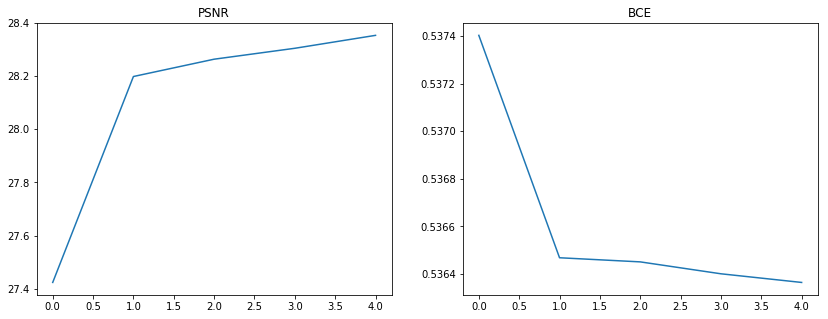

Memory allocated before clear: 7420.510208 MB
Memory allocated after clear: 97.517568 MB
----------
Data loaded (m): 1.61 @ [0, 1] in 0.5
----------
0 PSNR: 31.120238672695557, BCE: 0.5273301005363464, Time (m): 0.38
5 PSNR: 31.327631522829662, BCE: 0.5271649956703186, Time (m): 2.26
10 PSNR: 31.491841442613154, BCE: 0.5270852446556091, Time (m): 4.15
15 PSNR: 31.55657267842328, BCE: 0.5270531177520752, Time (m): 6.03
20 PSNR: 31.580989597257055, BCE: 0.527046263217926, Time (m): 7.92
----------
Train Time (m): 7.92


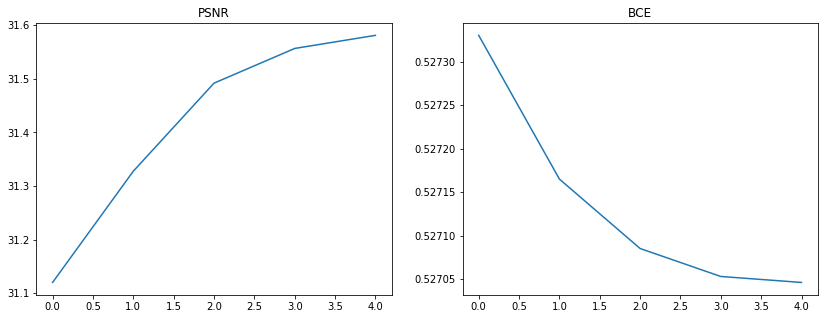

Memory allocated before clear: 4619.501568 MB
Memory allocated after clear: 97.517568 MB
----------
Data loaded (m): 2.56 @ [2] in 1
----------
0 PSNR: 30.579381936124527, BCE: 0.5249840021133423, Time (m): 1.07
5 PSNR: 30.829125863936873, BCE: 0.5247834920883179, Time (m): 6.41
10 PSNR: 30.81493226917444, BCE: 0.5248033404350281, Time (m): 11.76
15 PSNR: 30.849599941698465, BCE: 0.5247620940208435, Time (m): 17.11
20 PSNR: 30.927483928865644, BCE: 0.524606466293335, Time (m): 22.46
----------
Train Time (m): 22.46


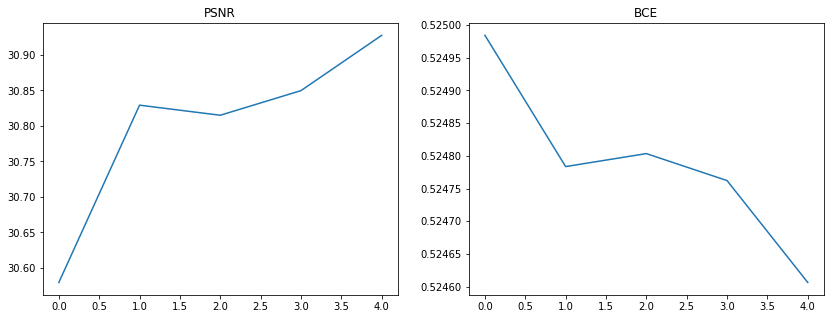

Memory allocated before clear: 7592.083456 MB
Memory allocated after clear: 97.517568 MB
----------
Data loaded (m): 1.87 @ [2, 3, 4] in 0.5
----------
0 PSNR: 31.27365835911718, BCE: 0.48857009410858154, Time (m): 0.45
5 PSNR: 31.49050975385694, BCE: 0.4883771538734436, Time (m): 2.7
10 PSNR: 31.73159475712863, BCE: 0.48814740777015686, Time (m): 4.94
15 PSNR: 31.858482029236118, BCE: 0.488071471452713, Time (m): 7.19
20 PSNR: 31.81197097865889, BCE: 0.48808854818344116, Time (m): 9.43
----------
Train Time (m): 9.43


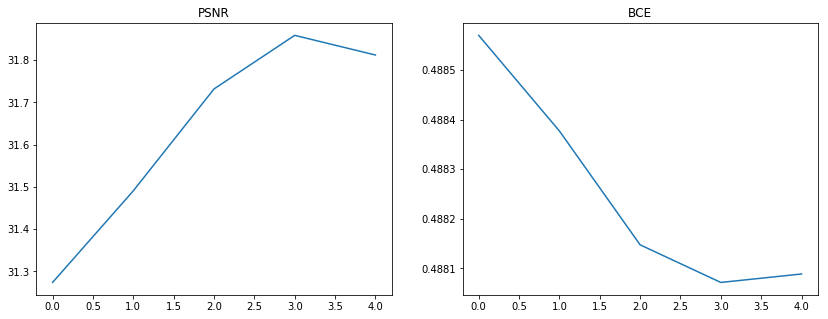

Memory allocated before clear: 4828.03712 MB
Memory allocated after clear: 97.517568 MB
----------
Data loaded (m): 1.17 @ [3] in 1
----------
0 PSNR: 29.048262475502895, BCE: 0.5324093699455261, Time (m): 0.47
5 PSNR: 29.196175147330056, BCE: 0.5323181748390198, Time (m): 2.8
10 PSNR: 29.203019903309265, BCE: 0.532292902469635, Time (m): 5.14
15 PSNR: 29.299670299129914, BCE: 0.5321916341781616, Time (m): 7.48
20 PSNR: 29.349254700058538, BCE: 0.5321516990661621, Time (m): 9.81
----------
Train Time (m): 9.81


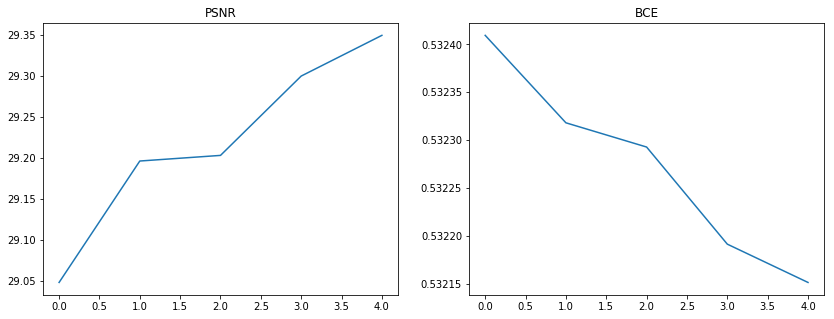

Memory allocated before clear: 6332.481536 MB
Memory allocated after clear: 97.517568 MB
----------
Data loaded (m): 2.81 @ [0, 1, 2, 3, 4, 5, 6] in 0.2
----------
0 PSNR: 28.53956042422563, BCE: 0.541364312171936, Time (m): 0.36
5 PSNR: 28.81683726718032, BCE: 0.5410577058792114, Time (m): 2.14
10 PSNR: 28.978054919313827, BCE: 0.5408990979194641, Time (m): 3.92
15 PSNR: 29.17907035045456, BCE: 0.5407440662384033, Time (m): 5.71
20 PSNR: 29.258221662353982, BCE: 0.5406888127326965, Time (m): 7.49
----------
Train Time (m): 7.49


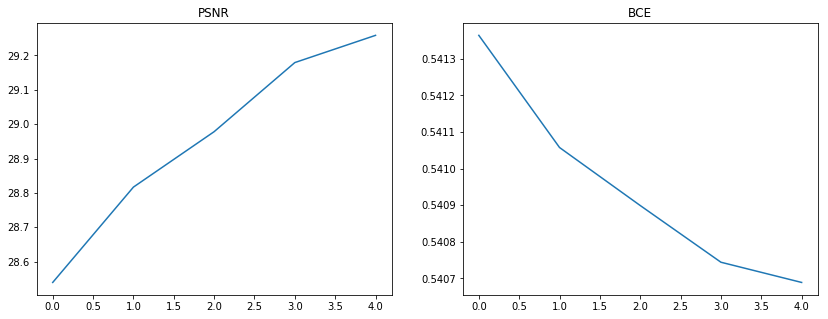

Memory allocated before clear: 1327.890432 MB
Memory allocated after clear: 6.291456 MB
----------
Data loaded (m): 2.04 @ [4] in 1
----------
0 PSNR: 31.106656088709116, BCE: 0.4971688687801361, Time (m): 0.84
5 PSNR: 31.16845919502845, BCE: 0.4968530535697937, Time (m): 5.09
10 PSNR: 31.753402433614966, BCE: 0.4964961111545563, Time (m): 9.34
15 PSNR: 31.603363595447213, BCE: 0.4965818226337433, Time (m): 13.59
20 PSNR: 31.820567793116442, BCE: 0.4964359402656555, Time (m): 17.84
----------
Train Time (m): 17.84


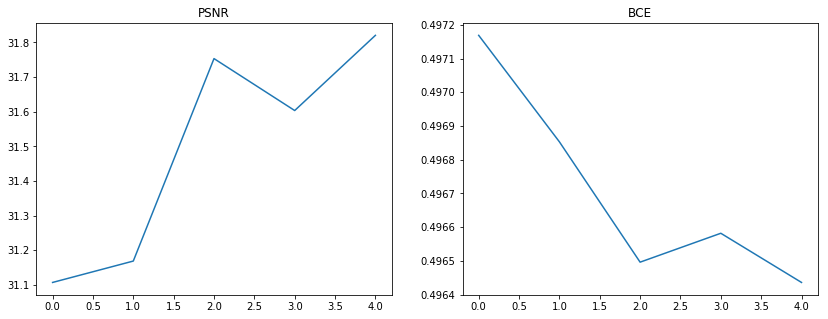

Memory allocated before clear: 7393.509376 MB
Memory allocated after clear: 373.948416 MB
----------
Data loaded (m): 1.32 @ [5, 6] in 0.5
----------
0 PSNR: 31.129555081856584, BCE: 0.5309984087944031, Time (m): 0.31
5 PSNR: 32.48229816514657, BCE: 0.5303450226783752, Time (m): 1.84
10 PSNR: 32.45844122667647, BCE: 0.530372679233551, Time (m): 3.38
15 PSNR: 32.52036908114658, BCE: 0.5302983522415161, Time (m): 4.91
20 PSNR: 32.5959093362801, BCE: 0.5302820205688477, Time (m): 6.45
----------
Train Time (m): 6.45


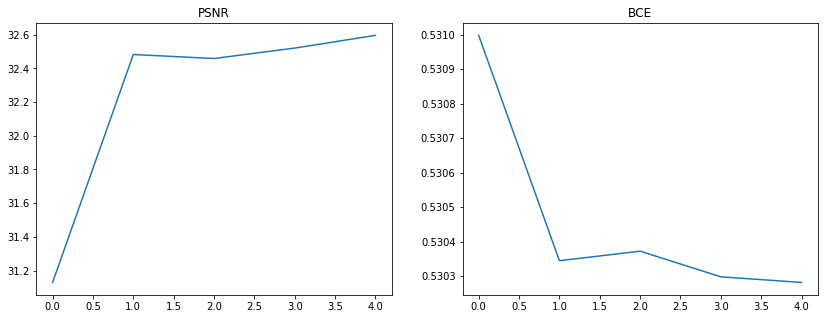

Memory allocated before clear: 4486.987776 MB
Memory allocated after clear: 97.517568 MB
----------
Data loaded (m): 1.93 @ [5] in 1
----------
0 PSNR: 29.758346997916767, BCE: 0.4950428307056427, Time (m): 0.8
5 PSNR: 29.835292482558458, BCE: 0.4950104057788849, Time (m): 4.85
10 PSNR: 29.89034764928735, BCE: 0.49489954113960266, Time (m): 8.9
15 PSNR: 29.990192391501918, BCE: 0.4948175251483917, Time (m): 12.95
20 PSNR: 29.992401420303118, BCE: 0.4948289394378662, Time (m): 17.0
----------
Train Time (m): 17.0


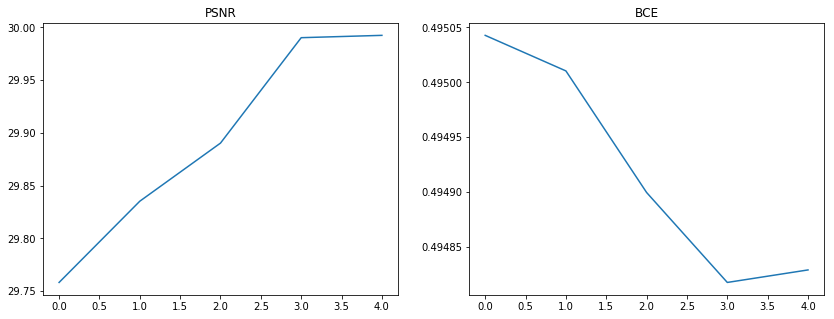

Memory allocated before clear: 7019.692032 MB
Memory allocated after clear: 97.517568 MB
----------
Data loaded (m): 2.03 @ [6] in 1
----------
0 PSNR: 30.359312048002675, BCE: 0.542054295539856, Time (m): 0.85
5 PSNR: 30.875583012870425, BCE: 0.5416977405548096, Time (m): 5.09
10 PSNR: 31.24193071332737, BCE: 0.5415033102035522, Time (m): 9.34
15 PSNR: 31.354189904160997, BCE: 0.5414572358131409, Time (m): 13.59
20 PSNR: 31.51714700146426, BCE: 0.5413386225700378, Time (m): 17.84
----------
Train Time (m): 17.84


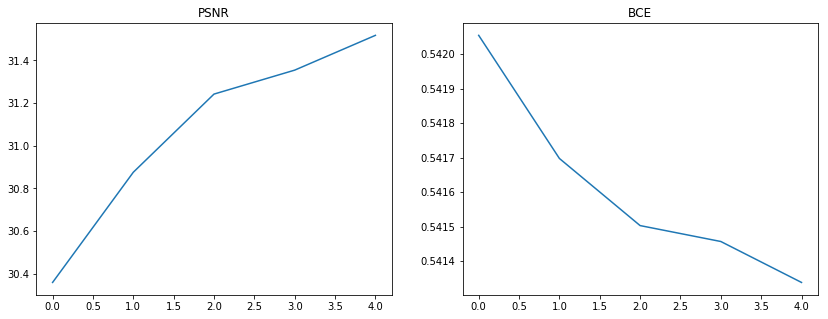

Memory allocated before clear: 7099.252736 MB
Memory allocated after clear: 97.517568 MB
----------
----------
FULL Time (m): 363.33


In [10]:
start = time.time()

for i in range(0, 2):
    psnr = train([0], epochs, batch_size, 1)
    psnr = train([1], epochs, batch_size, 1)
    psnr = train([0, 1], epochs, batch_size, 0.5)
    psnr = train([2], epochs, batch_size, 1)
    psnr = train([2, 3, 4], epochs, batch_size, 0.5)
    psnr = train([3], epochs, batch_size, 1)
    psnr = train([0, 1, 2, 3, 4, 5, 6], epochs, batch_size, 0.2)
    psnr = train([4], epochs, batch_size, 1)
    psnr = train([5, 6], epochs, batch_size, 0.5)
    psnr = train([5], epochs, batch_size, 1)
    psnr = train([6], epochs, batch_size, 1)

print('----------')
print(f'FULL Time (m): {round((time.time() - start) / 60, 2)}')

In [11]:
torch.save(model.cpu(), f'../data/models/1:1_x2_{psnr}.pt')

/home/alex/.local/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
